In [1]:
%pylab inline
import numpy as np
import scipy as sc
import scipy.ndimage as ndi
import pylab as pl
import matplotlib as mpl
from IPython import display
from itertools import islice
rc("image", cmap="gray")
import dlinputs as dli

Populating the interactive namespace from numpy and matplotlib


In [2]:
!ls testdata

imagenet-000000.tgz  nohup.out	sample.shards  uw3small.db
imagenet.shards      sample.db	sample.tgz


# Database Reader

Sqlite databases are convenient for local datasets. They can be up to several terabytes large. `itsqlite` returns dictionaries containing
each column as a field.

In [3]:
!sqlite3 testdata/sample.db .schema

CREATE TABLE train (image blob, cls integer, inx integer);


6


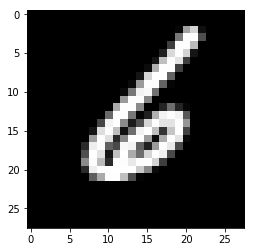

In [4]:
data = (dli.itsqlite("testdata/sample.db") |
        dli.itmap(image=dli.pilgray, cls=int))
for sample in data:
    imshow(sample["image"])
    print sample["cls"]
    break

# Tar Record Files

Tar record files are regular tar files. 

In [5]:
!tar -ztvf testdata/sample.tgz | sed 5q

-rw-r--r-- tmb/tmb           1 1970-01-01 00:00 10.cls
-rw-r--r-- tmb/tmb         306 1970-01-01 00:00 10.png
-rw-r--r-- tmb/tmb           1 1970-01-01 00:00 11.cls
-rw-r--r-- tmb/tmb         345 1970-01-01 00:00 11.png
-rw-r--r-- tmb/tmb           1 1970-01-01 00:00 12.cls
tar: write error


Consecutive files with the same
basename are returned as items in a dictionary; the extension is used
as the key to each entry.

In [6]:
data = dli.ittarreader("testdata/sample.tgz")
for sample in data:
    print sample.keys()
    print sample["__key__"]
    print repr(sample["cls"])
    print repr(sample["png"])[:30]
    break

['png', '__key__', 'cls']
10
'0'
'\x89PNG\r\n\x1a\n\x00\x00\x00


Usually, the output from an `ittarreader` is piped through something that decodes the string/buffer fields (`itmap`) and renames fields (`itren`). Decoders in `itmap` are just functions that map the contents of a field to new contents. The `dli.pilgray` function decodes a PNG-compressed image into a grayscale image represented as a numpy rank 2 array.

0


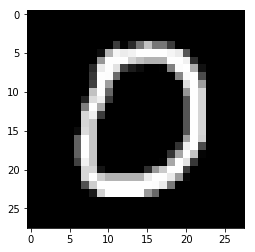

In [7]:
data = (dli.ittarreader("testdata/sample.tgz") |
        dli.itmap(png=dli.pilgray, cls=int) |
        dli.itren(image="png", cls="cls"))
for sample in data:
    imshow(sample["image"])
    print sample["cls"]
    break

The `ittarreader` can also read from URLs. This can be any web server, although often it is an S3-compatible storage server like Minio, Minio XL, Ceph, or Swift.

For desktop installations, the local Minio server is convenient.

In [8]:
!/bin/bash -c 'cd testdata && nohup python -m SimpleHTTPServer 9000 &'

nohup: appending output to 'nohup.out'


0


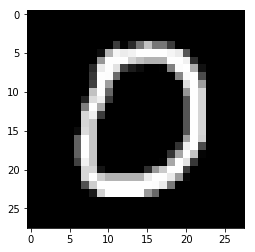

In [9]:
data = (dli.ittarreader("http://localhost:9000/sample.tgz") |
        dli.itmap(png=dli.pilgray, cls=int))
for sample in data:
    imshow(sample["png"])
    print sample["cls"]
    break

# Sharded Files

For larger datasets, sharding is a good idea. Shards are stored in JSON-formatted URLs.

In [10]:
!curl -s http://localhost:9000/imagenet.shards | sed 10q

/bin/sh: 1: curl: not found


Decoding is otherwise just like regular `ittarfile`. Note that the shard reader randomizes shard order by default.

304


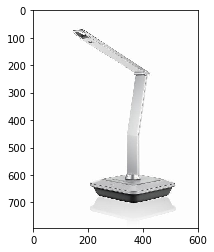

In [11]:
data = (dli.ittarshards("http://localhost:9000/imagenet.shards") |
        # dli.itinfo() |
        dli.itmap(png=dli.pilrgb, cls=int))
for sample in data:
    imshow(sample["png"])
    print sample["cls"]
    break

# Other Input Filters

There are more pipeline components:

- `itshuffle` shuffles samples inline
- `itstandardize` performs image size standardization
- `itbatch` performs batching of inputs

More are being added to `dlpipes`, including in-memory and on-disk caching, more data augmentation, and distributed and parallel pipes.

(5, 256, 256, 3)
[551 165 304 180 625]


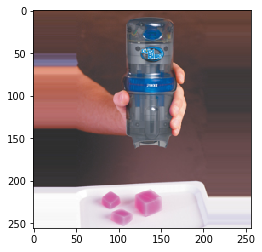

In [12]:
data = (dli.ittarshards("http://localhost:9000/imagenet.shards") |
        dli.itshuffle(1000) |
        dli.itmap(png=dli.pilrgb, cls=int) |
        dli.itren(image="png", cls="cls") |
        dli.itstandardize((256,256)) |
        dli.itbatch(5))
for sample in data:
    print sample["image"].shape
    imshow(sample["image"][0])
    print sample["cls"]
    break

# Loadable Inputs and Models

In many applications, it's useful to separate the input pipelines and model definitions from the source code of the application. The `dlpipes.loadable` module addresses this problem. It allows input pipelines and models to be defined with arbitrary Python code, but to be imported by file name rather than using the `import` statement.

In [13]:
!cat input-sample.py

#!/usr/bin/python

from dlpipes import inputs as dli

class Inputs(object):
    def training_data(self, **kw):
        return dli.itsqlite("testdata/sample.db", **kw) | \
               dli.itmap(image=dli.pilreads, cls=int)


Note that loadable input pipelines can be written using arbitrary Python code; they simply need to return Python iterators.

Different partitions of the dataset may get different `*_data` methods. You generally should have at least `training_data` and `test_data`. All and only datasets should have methods ending in `_data`.

Loadable input pipelines and models written in Python must end in `.py`; that's because the loader will eventually also load JSON and YAML definitions of pipelines and models.

In [14]:
factory = dli.loadable.load_input("input-sample.py")
training_data = factory.training_data()
training_data.next().keys()

# epoch 0 dbfile testdata/sample.db


['image', 'inx', '__epoch__', 'cls']

Defining dataset iterators in this way allows us to create useful tools that operate over datasets. For example, `show-input` provides information about a dataset iterators; optionally, it can also benchmark. There are other tools for broadcasting datasets over the network, dumping them into sharded files, etc.

In [15]:
!./show-input input-sample.py

datasets: training
showing: training

# epoch 0 dbfile testdata/sample.db
      __epoch__ 0
            cls 6
          image (28, 28) [0.0,1.0] 0.128111(0.300329773671)
            inx 999


# Client Server Pipelines

It is often useful to run some preprocessing code distributed on multiple CPU-only servers, then send the data on to the deep learning model on a GPU machine. The `zmqserver` and `itzmq` functions make this easy. These functions use a simple and time-efficient encoding of tensors in multipart ZMQ messages. With `itzmq`, it is also easily possible to connect to ZMQ-based servers written in other languages, to build efficient PUB/SUB training pipelines for training many models simultaneously, to build efficient wide area distribution trees for training data across data centers.

In [16]:
%%writefile server.py
import dlinputs as dli
data = dli.ittarreader("testdata/sample.tgz") | \
       dli.itmap(png=dli.pilrgb, cls=int)
dli.zmqserver(data, bind="tcp://*:17006")

Overwriting server.py


In [17]:
!/bin/bash -c 'python ./server.py &'

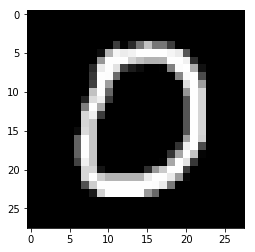

In [18]:
data = dli.itzmq(connect="tcp://localhost:17006")
imshow(data.next()["png"])

# Parallelizing Input Pipelines

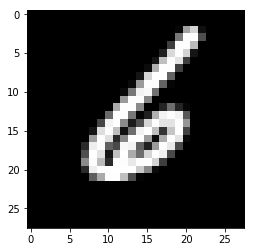

In [19]:
def factory():
    return dli.itsqlite("testdata/sample.db") | \
           dli.itmap(image=dli.pilreads, cls=int)
data = factory()
imshow(data.next()["image"])

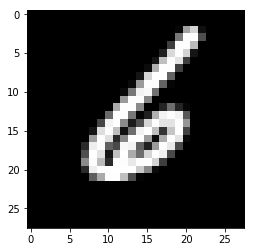

In [20]:
data = dli.parallel.parallelize_input(factory, 4)
imshow(data.next()["image"])